# Image Classification

In this jupyter lab notebook, we will train a neural network to classify happy and sad smilies :)

## Import
Here we import libraries we will use in order to code our example.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import pathlib

# set a seed to have reproducible results
tf.keras.utils.set_random_seed(
    1408
)

## Prepare our dataset
We photographed and cut out all the smilies you drew. We put all the happy smilies in a folder called "happy" and all the sad ones in a folder called "sad".

Also, we took a small part of the smilies (equal amount of sad and happy ones) and moved them to another folder. These smileys will not be seen by our network and we use them only to check how well our network can already recognize new 'unknown' smilies.

In [2]:
# the smilies we will use to train the network
smilies_dir_train = pathlib.Path("data/smilies_train")
# the smilies we will use to evalute the network
smilies_dir_val = pathlib.Path("data/smilies_val")

In [3]:
image_count = len(list(smilies_dir_train.glob('*/*.PNG')))
print(f"We have {image_count} images loaded and ready to use :)")

We have 291 images loaded and ready to use :)


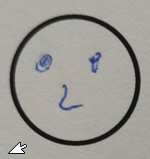

In [4]:
# we take a random 'happy' smiley to ensure we did everything correct
happy = list(smilies_dir_train.glob('happy/*'))
PIL.Image.open(str(happy[0]))

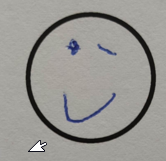

In [5]:
# and another one
PIL.Image.open(str(happy[1]))

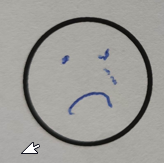

In [6]:
# we do the same for the sad smileys to be extra sure
sad = list(smilies_dir_train.glob('sad/*'))
PIL.Image.open(str(sad[0]))

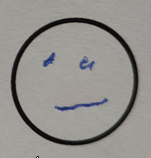

In [7]:
# and another one
PIL.Image.open(str(sad[1]))

## Create a tensorflow dataset

Our images are now ready and stored in the named folders. Keras allows us to simply load this folder into our program. Whether it is a happy or sad smiley, Keras recognizes it by the folder name.

The images are loaded into a so-called dataset. From there we can easily access them to train the model or to further process the images.

When working with neural networks, it is common to show the network several images at the same time in one step. This helps it to learn features that appear in several images and can also shorten the training time.
How many such images the network sees in one step is configured by the batch size. Usually one takes a large number, even several hundred images. Since our dataset is not that large today, we will work with a batch size of 4.

Today our network can only work with images of the same size, but since we cut them out ourselves, by hand, it is also important to bring them to a uniform size. Here we use 64x64 pixels.


In [8]:
# Set some hyperparameters
batch_size = 4
img_height = 64
img_width = 64

In [9]:
# load the data in our train dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    smilies_dir_train,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 291 files belonging to 2 classes.


In [10]:
# load the data in our validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    smilies_dir_val,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 40 files belonging to 2 classes.


In [11]:
class_names = train_ds.class_names
print(class_names)

['happy', 'sad']


We take a look at the samples in our dataset - so we can ensure everything worked out so far.

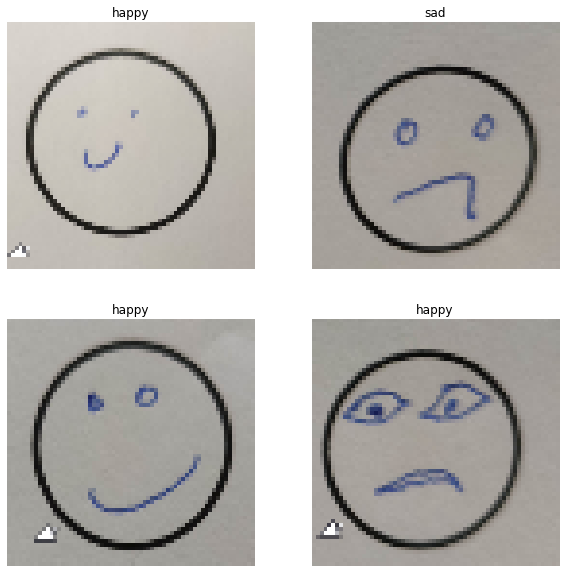

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [13]:
# check dimensions of batch with multiple images
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(4, 64, 64, 3)
(4,)


In [14]:
# code to optimize the use of buffer when loading data
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
# pixel values will be between 0 and 1 afterwards
normalization_layer = layers.Rescaling(1./255)

In [16]:
# check if normalization worked
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0., 1]`.
print(np.min(first_image), np.max(first_image))

0.10441177 0.82823324


### Convolutional layer
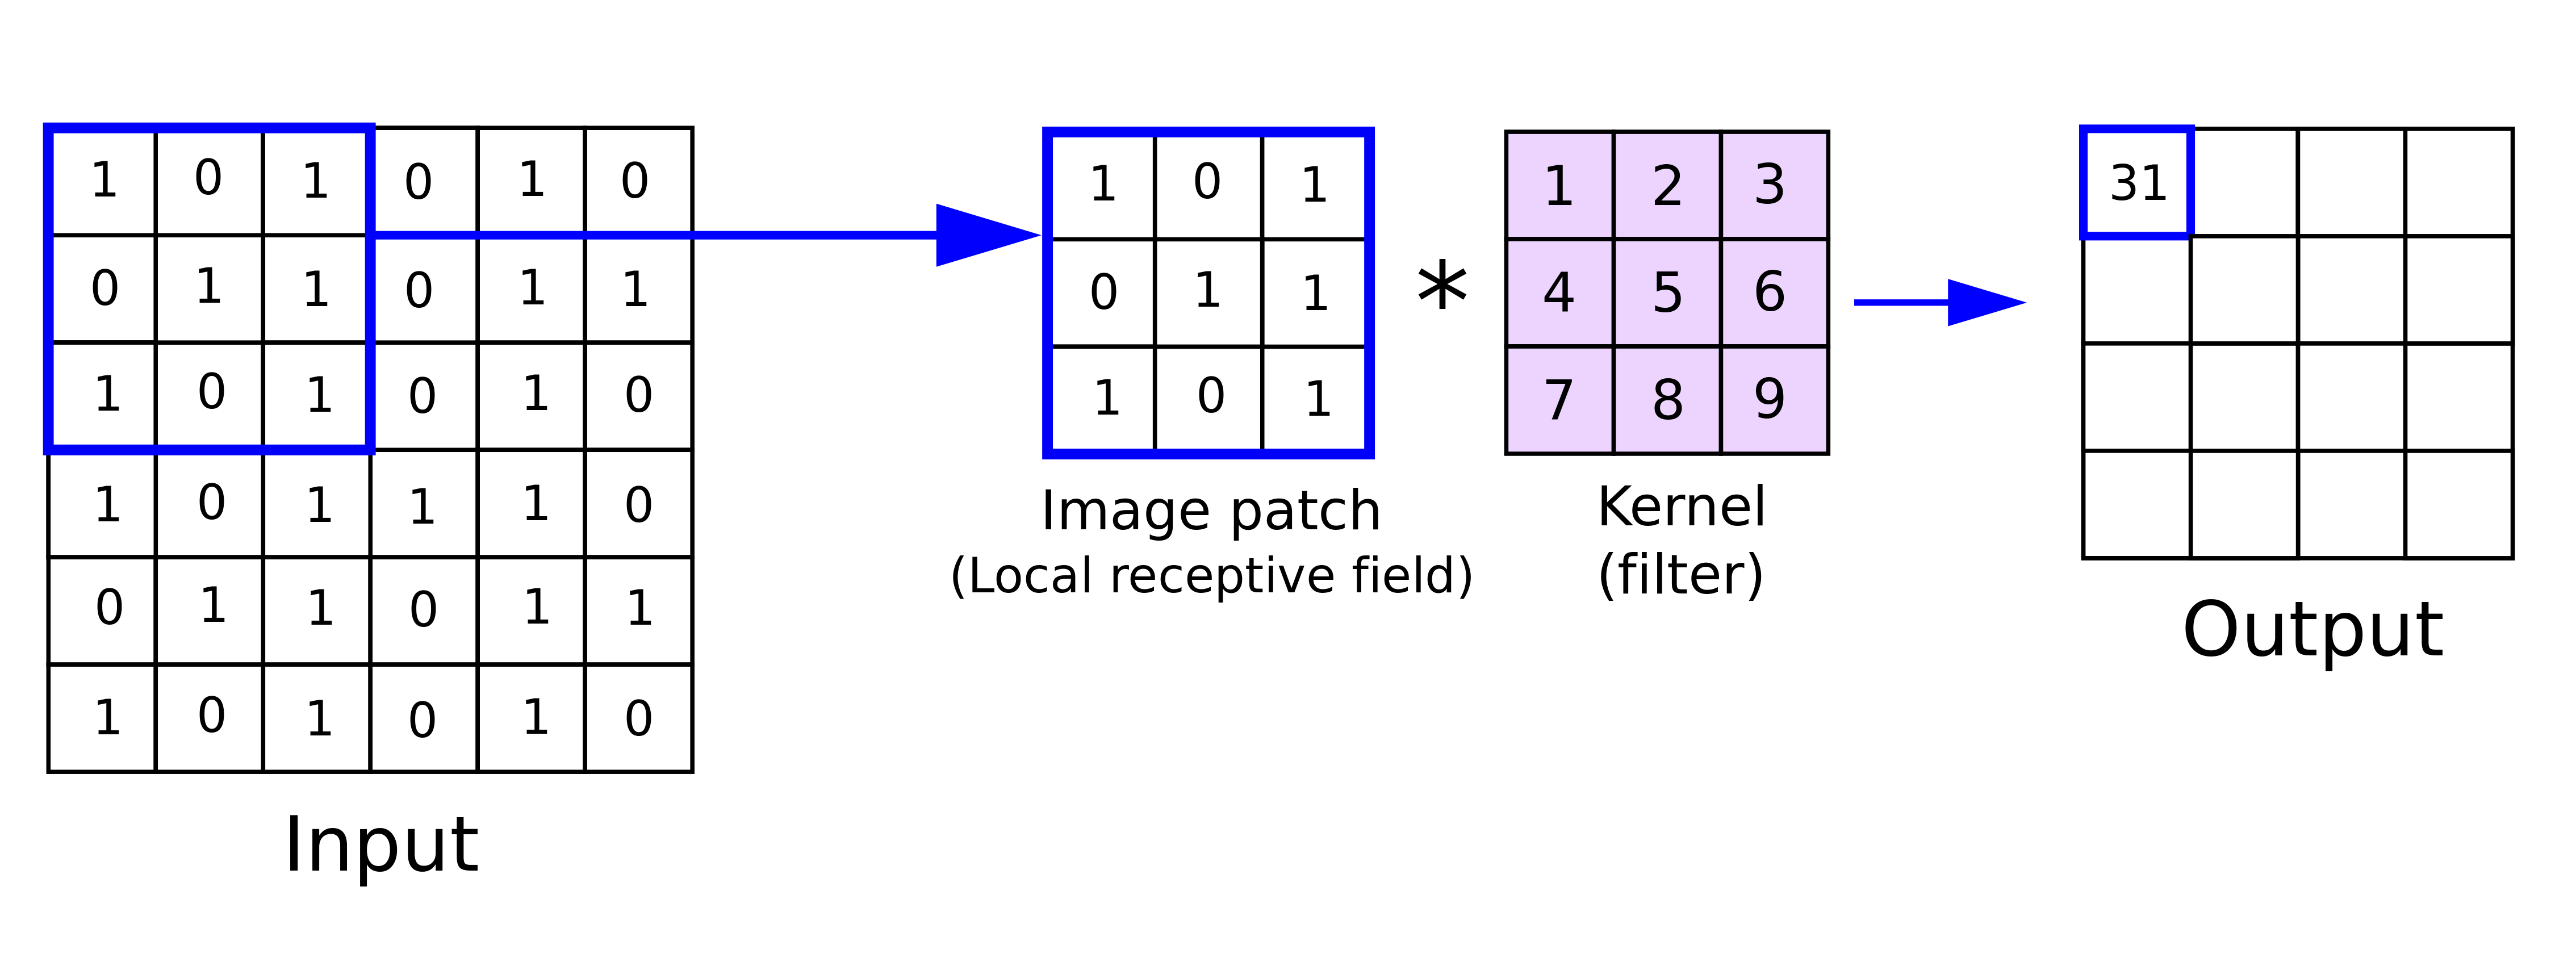


In [17]:
# how many classes do we have?
num_classes = len(class_names)

# create neural network
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    # here is our convolutional layer -> 8 Kernels, Kernel Size = 3x3, padding to keep dimension of image
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    # here is our convolutional layer -> 16 Kernels, Kernel Size = 3x3, padding to keep dimension of image
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    # reduce our image dimension here
    layers.MaxPooling2D(pool_size=(2, 2)),
    # we flatten our images to get 1D data
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    # here we use two outputs - the higher one determines the predicted class
    layers.Dense(num_classes)
])

In [18]:
# we want to minimize the loss - and use the adam optimizer to do this
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [19]:
# how does our model look like
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 32)                1048608   
                                                        

### Fully connected layer
![image](https://miro.medium.com/max/439/1*sVvC9YwPFD5RJ9xgxrYHPw.png)

In [20]:
%%time

# lets train for 10 epochs
epochs = 10

# here the actual training happens
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
73/73 [==============================] - 1s 15ms/step - loss: 0.7036 - accuracy: 0.5704 - val_loss: 0.6227 - val_accuracy: 0.6750
Epoch 2/10
73/73 [==============================] - 1s 13ms/step - loss: 0.5483 - accuracy: 0.7251 - val_loss: 0.5077 - val_accuracy: 0.8000
Epoch 3/10
73/73 [==============================] - 1s 13ms/step - loss: 0.3240 - accuracy: 0.8797 - val_loss: 0.3171 - val_accuracy: 0.9000
Epoch 4/10
73/73 [==============================] - 1s 14ms/step - loss: 0.2025 - accuracy: 0.9175 - val_loss: 0.3799 - val_accuracy: 0.8250
Epoch 5/10
73/73 [==============================] - 1s 14ms/step - loss: 0.1380 - accuracy: 0.9519 - val_loss: 0.4457 - val_accuracy: 0.8500
Epoch 6/10
73/73 [==============================] - 1s 13ms/step - loss: 0.1458 - accuracy: 0.9519 - val_loss: 0.4258 - val_accuracy: 0.9000
Epoch 7/10
73/73 [==============================] - 1s 14ms/step - loss: 0.0460 - accuracy: 0.9897 - val_loss: 0.4429 - val_accuracy: 0.8500
Epoch 8/10
73

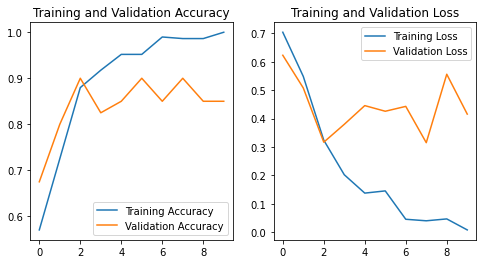

In [21]:
# just some code to plot the training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Now we have the first predictions from our trained model. Let's have a look at the examples we have reserved for validation. 

The left value is the correct class, the right value is the class predicted by our model. 

1/1 [==============================] - 0s 16ms/step


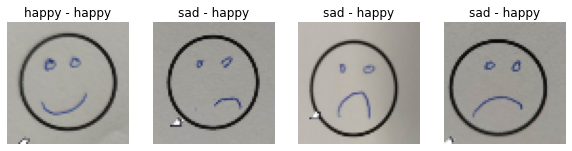

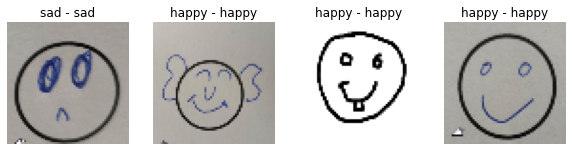

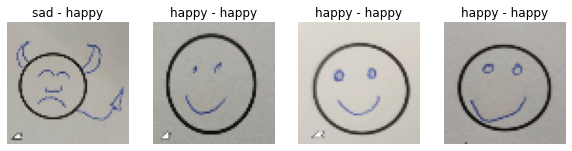

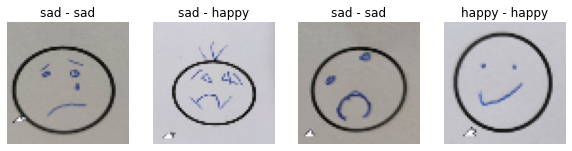

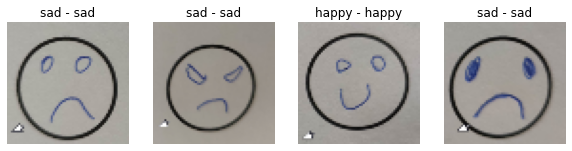

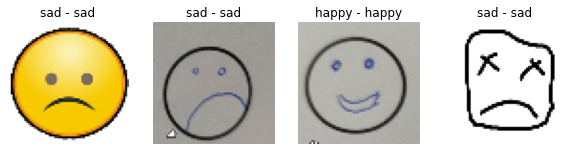

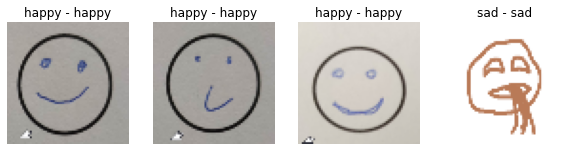

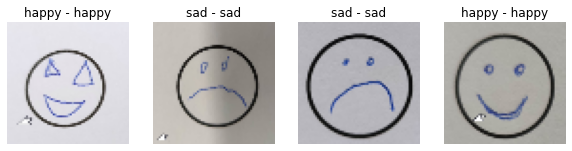

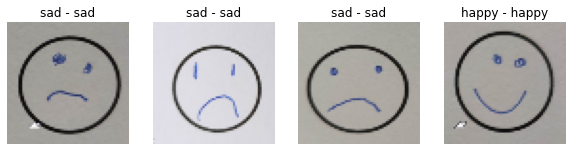

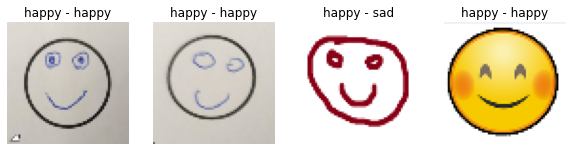

In [22]:
for element, labels in val_ds:
    predictions = model.predict(element)
    batch_len = len(predictions)
    
    plt.figure(figsize=(10, 10))
    for idx, (image, label, prediction) in enumerate(zip(element, labels, predictions)):
        ax = plt.subplot(1, 4, idx + 1)
        img = image.numpy().astype("uint8")
        plt.imshow(img)
        pred_label = class_names[np.argmax(prediction)]
        plt.title(f"{class_names[label]} - {pred_label}")
        plt.axis("off")


## Publikumsbefragung:
### We observed some problems here
- auswending lernen (overfitting)

#### How can we get better?
- mehr smilies in den Daten
- Daten vor-bearbeiten
- mehr Trainingszeit
- weniger Trainingszeit
- größeres Netzwerk
- anderes Netzwerk
- vortrainiertes Netzwerk


## Improvement: Data Augmentation

In [23]:
# here we augment the data
data_augmentation = keras.Sequential(
  [
    # we randomly flip them horizonatally  
    layers.RandomFlip(
        "horizontal",
        input_shape=(img_height,img_width, 3)),
    # we randomly rotate them
    layers.RandomRotation(0.1),
    # we randomly zoom
    layers.RandomZoom(0.1),
  ]
)

def augment(img):   
    return data_augmentation(img)

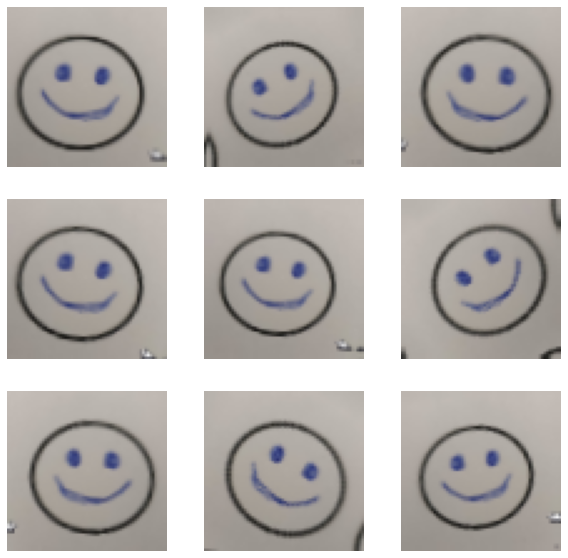

In [24]:
plt.figure(figsize=(10, 10))
for images_raw, _ in train_ds:
    for i in range(9):
        augmented_images = augment(images_raw)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")
    break

In [25]:
model = Sequential([
    # here we add the additional data augmentation layer:
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(num_classes)
])

In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 64, 64, 3)         0         
                                                                 
 rescaling_2 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 16)        448       
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                      

In [28]:
%%time
# once again we train the model with some more epochs, 
#  because we do not fear overfitting so much with the augmentation
epochs = 16
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/16
73/73 [==============================] - 2s 19ms/step - loss: 0.6803 - accuracy: 0.5773 - val_loss: 0.6082 - val_accuracy: 0.6000
Epoch 2/16
73/73 [==============================] - 1s 18ms/step - loss: 0.6424 - accuracy: 0.6323 - val_loss: 0.4995 - val_accuracy: 0.8000
Epoch 3/16
73/73 [==============================] - 1s 17ms/step - loss: 0.6125 - accuracy: 0.6976 - val_loss: 0.3587 - val_accuracy: 0.8750
Epoch 4/16
73/73 [==============================] - 1s 18ms/step - loss: 0.4669 - accuracy: 0.7938 - val_loss: 0.3749 - val_accuracy: 0.9000
Epoch 5/16
73/73 [==============================] - 1s 18ms/step - loss: 0.4256 - accuracy: 0.8213 - val_loss: 0.5386 - val_accuracy: 0.8250
Epoch 6/16
73/73 [==============================] - 1s 18ms/step - loss: 0.3829 - accuracy: 0.8419 - val_loss: 0.5858 - val_accuracy: 0.8250
Epoch 7/16
73/73 [==============================] - 1s 18ms/step - loss: 0.3471 - accuracy: 0.8625 - val_loss: 0.6388 - val_accuracy: 0.8500
Epoch 8/16
73

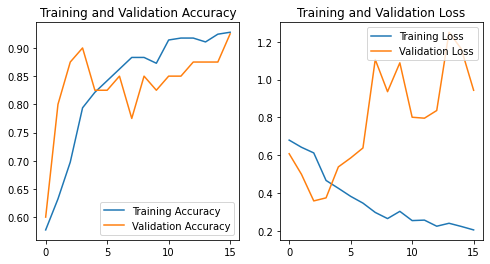

In [29]:
# same plotting code again
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 [==============================] - 0s 17ms/step


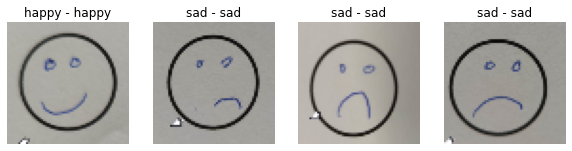

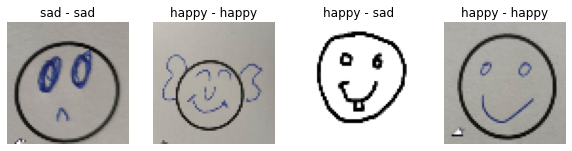

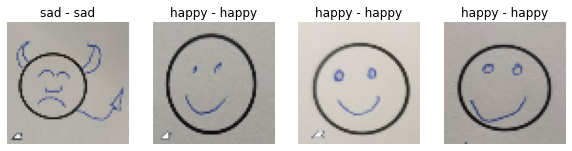

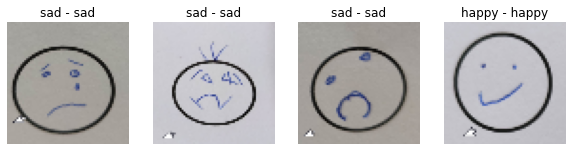

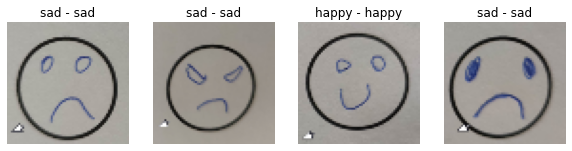

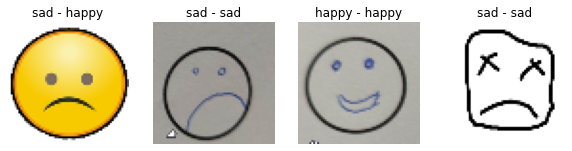

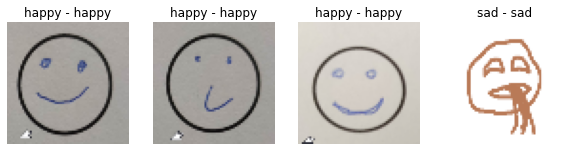

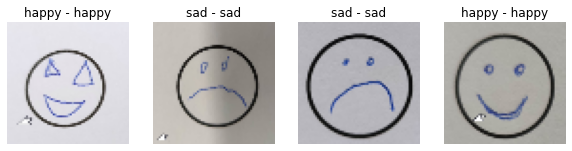

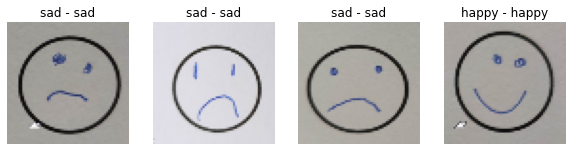

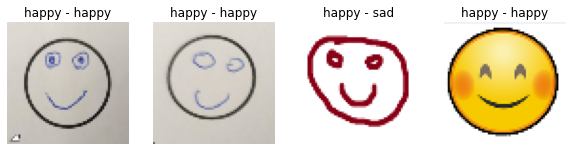

In [30]:
for element, labels in val_ds:
    predictions = model.predict(element)
    batch_len = len(predictions)
    
    plt.figure(figsize=(10, 10))
    for idx, (image, label, prediction) in enumerate(zip(element, labels, predictions)):
        ax = plt.subplot(1, 4, idx + 1)
        img = image.numpy().astype("uint8")
        plt.imshow(img)
        pred_label = class_names[np.argmax(prediction)]
        plt.title(f"{class_names[label]} - {pred_label}")
        plt.axis("off")


## Improvement: Dropout
Another way to reduce overfitting might be "dropout": some neurons will be set to 0 during training.

In [31]:
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    # we add the dropout layer here
    layers.Dropout(0.05),
    layers.Dense(num_classes)
])

In [32]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [33]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 64, 64, 3)         0         
                                                                 
 rescaling_3 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 16)        448       
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0         
                                                      

In [34]:
%%time
epochs = 12
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/12
73/73 [==============================] - 2s 19ms/step - loss: 0.8585 - accuracy: 0.4536 - val_loss: 0.6891 - val_accuracy: 0.7250
Epoch 2/12
73/73 [==============================] - 1s 18ms/step - loss: 0.6907 - accuracy: 0.6117 - val_loss: 0.6634 - val_accuracy: 0.5750
Epoch 3/12
73/73 [==============================] - 1s 18ms/step - loss: 0.6614 - accuracy: 0.6220 - val_loss: 0.6153 - val_accuracy: 0.6250
Epoch 4/12
73/73 [==============================] - 1s 17ms/step - loss: 0.6608 - accuracy: 0.6048 - val_loss: 0.6397 - val_accuracy: 0.7000
Epoch 5/12
73/73 [==============================] - 1s 17ms/step - loss: 0.6191 - accuracy: 0.6632 - val_loss: 0.5184 - val_accuracy: 0.8000
Epoch 6/12
73/73 [==============================] - 1s 17ms/step - loss: 0.5389 - accuracy: 0.7595 - val_loss: 0.6704 - val_accuracy: 0.7750
Epoch 7/12
73/73 [==============================] - 1s 17ms/step - loss: 0.5223 - accuracy: 0.7595 - val_loss: 0.6920 - val_accuracy: 0.7750
Epoch 8/12
73

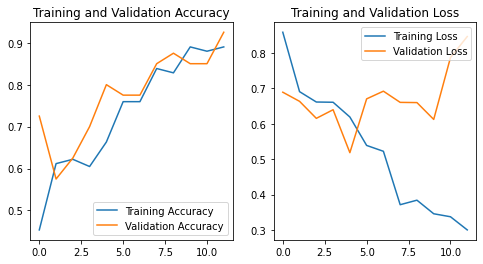

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Visualization
In this area, we can visualize what the neural network predicts on our validation set.

1/1 [==============================] - 0s 17ms/step


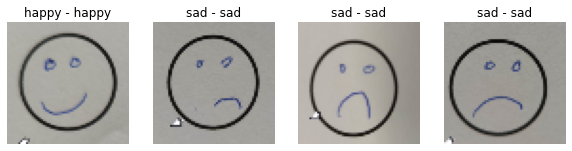

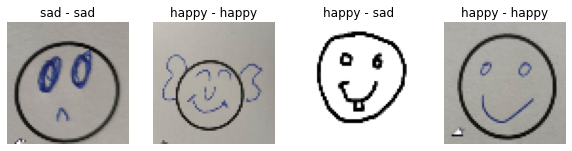

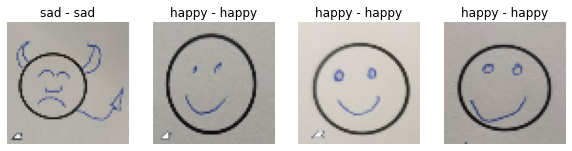

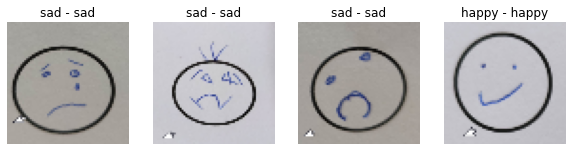

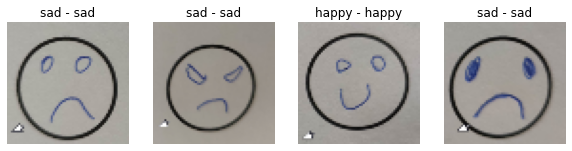

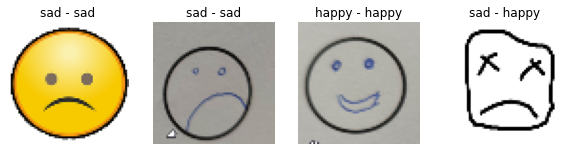

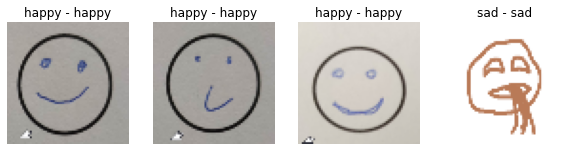

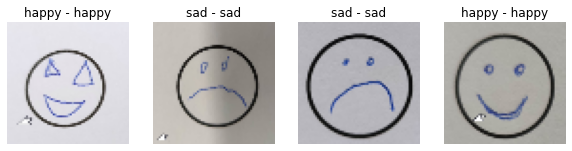

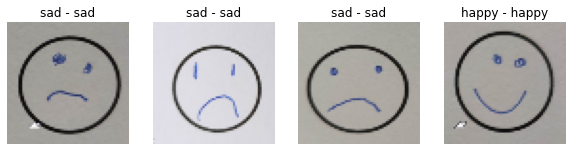

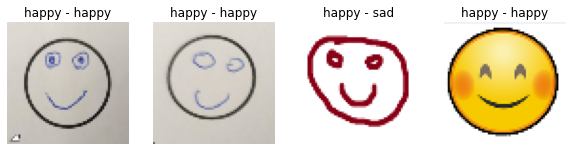

In [36]:
for element, labels in val_ds:
    predictions = model.predict(element)
    batch_len = len(predictions)
    
    plt.figure(figsize=(10, 10))
    for idx, (image, label, prediction) in enumerate(zip(element, labels, predictions)):
        ax = plt.subplot(1, 4, idx + 1)
        img = image.numpy().astype("uint8")
        plt.imshow(img)
        pred_label = class_names[np.argmax(prediction)]
        plt.title(f"{class_names[label]} - {pred_label}")
        plt.axis("off")


# Thank you!
If you read this you really deserve a big THANK YOU!

THANK YOU for participating, you are awesome!
Now it's up to you! Use this notebook as a template and train you own network!
Just exchange the folders with your training data, you can even add more classes or whatever you like!
Be creative! Have FUN!

Bye - Raphael and Paul

## Contact
If you have any questions, don't hesitate to write me on
* linkedin: https://www.linkedin.com/in/paul-puntschart-279506a2/
* email: paul.puntschart@cloudflight.io